In [1]:
import sys
sys.path.append("../standard-algorithms")

from julia import install as julia_install
from julia.api import Julia

julia_install()
# ubuntu/debian/conda static linkage to libpython workaround
# set to True if you have a different python distribution
# otherwise it significantly bloats the initial loading time.
jl = Julia(compiled_modules=False)
from julia import Main
import numpy as np
import importlib

In [2]:
Main.include("./test_bluemesh7.jl")

<PyCall.jlwrap Main.BlueMesh7>

In [3]:
jl.using(".BlueMesh7")
BlueMesh7 = Main.BlueMesh7

In [4]:
import greedy_algorithms
greedy_algorithms = importlib.reload(greedy_algorithms)
greedy_connect_without_prune = greedy_algorithms.greedy_connect_without_prune
greedy_connect = greedy_algorithms.greedy_connect
show_graph_with_labels = greedy_algorithms.show_graph_with_labels

In [5]:
import dominator_algorithm
dominator_algorithm = importlib.reload(dominator_algorithm)
dominator = dominator_algorithm.dominator

In [6]:
positions = BlueMesh7.generate_positions(dims=(50, 20), n=90)

In [7]:
def rssi_map_to_adjacency(rssi_map, sensetivity):
    mask = rssi_map > sensetivity
    adjacency = np.zeros(rssi_map.shape, dtype=np.uint8)
    adjacency[mask] = 1
    return adjacency[1:, 1:]

In [8]:
all_node_roles = np.ones(len(positions), dtype='i8')
all_mesh = BlueMesh7.initialize_mesh(positions, all_node_roles)

In [9]:
adjacency = rssi_map_to_adjacency(all_mesh.properties['rssi_map'], all_mesh.properties['scanner_sensitivity'])

### Set all agents in relay mode

Selected 90 relays out of 90 (100.0%)


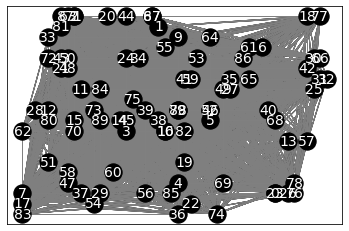

running the simulation for 1 minute (60000 steps, 1 step = 1ms)...
Packet delivery rate: 0.86, Worst delivery rate: 1.00, Average delay: 14.40ms


In [10]:
num_relays = len(positions)
print(f"Selected {num_relays} relays out of {len(positions)} ({100 * num_relays / len(positions)}%)")

show_graph_with_labels(adjacency, all_node_roles, positions)


print("running the simulation for 1 minute (60000 steps, 1 step = 1ms)...")
stats = BlueMesh7.start(all_mesh, minutes=1)
print(f"Packet delivery rate: {stats.PDR:.2f}, Worst delivery rate: {stats.worstPDR:.2f}, Average delay: {stats.delay:.2f}ms")


### GreedyConnect

Selected 2 relays out of 90 (2.22%)


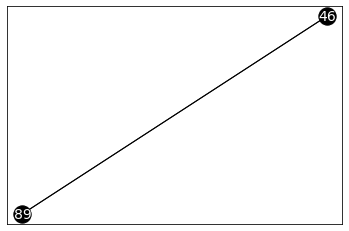

running the simulation for 1 minute (60000 steps, 1 step = 1ms)...
Packet delivery rate: 0.32, Worst delivery rate: 1.00, Average delay: 29.86ms


In [11]:
greedy_node_roles = greedy_connect(adjacency)
greedy_mesh = BlueMesh7.initialize_mesh(positions, greedy_node_roles)

num_relays = np.count_nonzero(greedy_node_roles)
print(f"Selected {num_relays} relays out of {len(positions)} ({100 * num_relays / len(positions):.2f}%)")

show_graph_with_labels(adjacency, greedy_node_roles, positions, only_relays=True)


print("running the simulation for 1 minute (60000 steps, 1 step = 1ms)...")
greedy_stats = BlueMesh7.start(greedy_mesh, minutes=3)
print(f"Packet delivery rate: {greedy_stats.PDR:.2f}, Worst delivery rate: {greedy_stats.worstPDR:.2f}, Average delay: {greedy_stats.delay:.2f}ms")


### Dominator

Selected 27 relays out of 90 (30.00%)


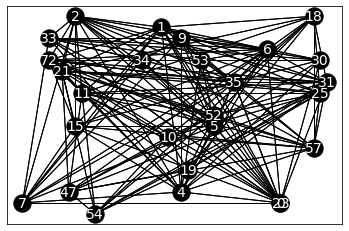

running the simulation for 1 minute (60000 steps, 1 step = 1ms)...
Packet delivery rate: 0.77, Worst delivery rate: 1.00, Average delay: 20.15ms


In [12]:
dominator_node_roles = dominator(adjacency)
dominator_mesh = BlueMesh7.initialize_mesh(positions, dominator_node_roles)

num_relays1 = np.count_nonzero(dominator_node_roles)
print(f"Selected {num_relays1} relays out of {len(positions)} ({100 * num_relays1 / len(positions):.2f}%)")

show_graph_with_labels(adjacency, dominator_node_roles, positions, only_relays=True)

print("running the simulation for 1 minute (60000 steps, 1 step = 1ms)...")
dominator_stats = BlueMesh7.start(dominator_mesh, minutes=3)
print(f"Packet delivery rate: {dominator_stats.PDR:.2f}, Worst delivery rate: {dominator_stats.worstPDR:.2f}, Average delay: {dominator_stats.delay:.2f}ms")